# About this Workbook
***
This workbook highlights the technique of association analysis. This is widely used in Advanced Analytics teams since it has use cases such as similar product recommendations, inventory placement on your sales floor, or for just identifying similar parts that are replaced or purchasesd together.

### Workbook Setup

In [1]:
# import the required python libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import os
import warnings 
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.options.display.float_format = "{:,.2f}".format

In [2]:
# Set seaborn styles
sns.set(font_scale=1.6)
sns.set_style(style='whitegrid',
              rc={'axes.spines.left': True
                 ,'axes.spines.bottom': True
                 ,'axes.spines.top': False
                 ,'axes.spines.bottom': True
                 ,'axes.spines.right': False
                 ,'axes.spines.left': True
                 ,'axes.facecolor': 'white'
                 ,'axes.edgecolor': 'lightgray'
                 ,'ytick.left': True
                 ,'xtick.bottom': True
                 ,'grid.linestyle': '--'
                 ,'font.family': ['Arial']})

In [66]:
# read in dataset. This is stored in my local repo but is not tracked in the remote repository.
# the "../" is to go back two folders since I store the data in the root of my local repository.
data = pd.read_csv("../../data/Groceries_dataset.csv")

### Logical Approach
A logical approach to this problem means that we want to see the most frequently purchased parts. Finding patterns as to what other parts are purchased will need to be infered.

In [67]:
data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [68]:
# Update column names
data.columns = ['member_id', 'date', 'item_desc']

In [75]:
# Aggregate data frame in order to create matrix
# First create an ID for each transaction. If your data has invoice numbers or any other identifier like that then this step isn't necessary.
data['id'] = data['date'] + '-' + data['member_id'].astype(str)

logical_df = (
    data.groupby('item_desc', as_index=False)
    .agg(
        count=('item_desc', 'count')        
    )
)
logical_df['transactions'] = data['id'].nunique()

In [76]:
# Create a percent in transactions variable
logical_df['pct'] = logical_df['count'] / logical_df['transactions']

In [79]:
# sort values by the pct column in descending order and show the top 15
logical_df.sort_values(by='pct', ascending=False)[:15]

,item_desc,count,transactions,pct
164,whole milk,2502,14963,0.17
102,other vegetables,1898,14963,0.13
122,rolls/buns,1716,14963,0.11
138,soda,1514,14963,0.10
165,yogurt,1334,14963,0.09
123,root vegetables,1071,14963,0.07
156,tropical fruit,1032,14963,0.07
12,bottled water,933,14963,0.06
130,sausage,924,14963,0.06
30,citrus fruit,812,14963,0.05


### Association Rule Mining

In [33]:
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [80]:
# Starting by looking at the data we're working with.
# I use a random sample of 5 rows. The random state ensures that I see the same sample each time.
data.sample(5, random_state=9)

,member_id,date,item_desc,id
7925,2201,22-05-2015,bottled water,22-05-2015-2201
38212,3563,14-08-2014,candy,14-08-2014-3563
23168,3772,18-02-2015,waffles,18-02-2015-3772
16764,2289,04-11-2015,tropical fruit,04-11-2015-2289
5500,2415,08-08-2015,newspapers,08-08-2015-2415


In [81]:
# Update date column data type
# I have to use to_datetime twice since the date is stored as dd-mm-yyyy
data['date'] = pd.to_datetime(pd.to_datetime(data["date"]).dt.strftime('%Y-%m-%d'))

In [82]:
# Create a transaction ID. This is only applicable to this dataset. Your data might already have this indicator.
data['invoice'] = data['date'].astype(str) + '-' + data['member_id'].astype(str)

In [83]:
market_basket_data = data[['invoice', 'item_desc']]
market_basket_data['item_desc'] = market_basket_data['item_desc'].str.strip()

In [84]:
market_basket_data.head()

,invoice,item_desc
0,2015-07-21-1808,tropical fruit
1,2015-05-01-2552,whole milk
2,2015-09-19-2300,pip fruit
3,2015-12-12-1187,other vegetables
4,2015-01-02-3037,whole milk


In [85]:
# Show transactions for member id 1808
market_basket_data[market_basket_data['invoice'].str.contains('1808')].sort_values(by='invoice')

,invoice,item_desc
9090,2014-11-29-1808,meat
25239,2014-11-29-1808,whole milk
11488,2014-12-15-1808,sugar
27637,2014-12-15-1808,citrus fruit
38731,2014-12-15-1808,napkins
4355,2015-04-02-1808,long life bakery product
20504,2015-04-02-1808,semi-finished bread
0,2015-07-21-1808,tropical fruit
16149,2015-07-21-1808,rolls/buns
36088,2015-07-21-1808,candy


The above format is how we need to set up the data for the alorithm.

In [86]:
# Now we need to update the data to where we have 1 transaction per row with the items as columns.
basket = (
    market_basket_data.groupby('invoice')['item_desc']
    .apply(list).reset_index()
)
transactions = basket.item_desc.to_list()

In [87]:
# Show the reformatted transactions. Each invoice has their items stored in a list.
basket.head()

,invoice,item_desc
0,2014-01-01-1249,"[citrus fruit, coffee]"
1,2014-01-01-1381,"[curd, soda]"
2,2014-01-01-1440,"[other vegetables, yogurt]"
3,2014-01-01-1659,"[specialty chocolate, frozen vegetables]"
4,2014-01-01-1789,"[hamburger meat, candles]"


In [111]:
# Enable transaction encoder
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

In [112]:
basket_encoded = pd.DataFrame(te_array, columns = te.columns_)

In [149]:
# Get the frequent itemsets
freq_items = fpgrowth(basket_encoded, min_support=0.001, use_colnames=True)

In [150]:
rules = association_rules(freq_items, metric='lift', min_threshold=0.5)

In [151]:
rules = rules.sort_values(by='lift', ascending=False).reset_index(drop=True)

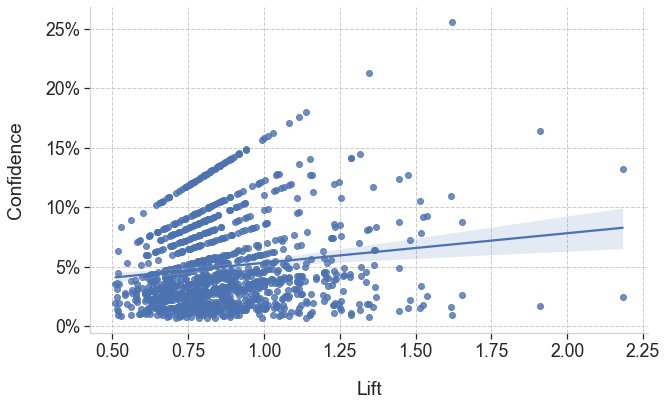

In [152]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='lift', y='confidence', data=rules)
plt.xlabel("Lift", labelpad=20)
plt.ylabel("Confidence", labelpad=20)
ax.set_yticklabels(["{:,.0%}".format(x) for x in ax.get_yticks()])
plt.show()

In [156]:
rules.sort_values(by='confidence', ascending=False)[:15]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,"(yogurt, sausage)",(whole milk),0.01,0.16,0.00,0.26,1.62,0.00,1.13
36,"(rolls/buns, sausage)",(whole milk),0.01,0.16,0.00,0.21,1.35,0.00,1.07
110,"(sausage, soda)",(whole milk),0.01,0.16,0.00,0.18,1.14,0.00,1.03
129,(semi-finished bread),(whole milk),0.01,0.16,0.00,0.18,1.11,0.00,1.02
148,"(rolls/buns, yogurt)",(whole milk),0.01,0.16,0.00,0.17,1.08,0.00,1.02
2,"(sausage, whole milk)",(yogurt),0.01,0.09,0.00,0.16,1.91,0.00,1.09
202,(detergent),(whole milk),0.01,0.16,0.00,0.16,1.03,0.00,1.01
217,(ham),(whole milk),0.02,0.16,0.00,0.16,1.01,0.00,1.00
241,(bottled beer),(whole milk),0.05,0.16,0.01,0.16,1.00,-0.00,1.00
247,(frozen fish),(whole milk),0.01,0.16,0.00,0.16,0.99,-0.00,1.00


In [160]:
# Exclude milk from rules to see other associations
rules[
    (~rules['consequents'].astype(str).str.contains('milk'))
    & (~rules['antecedents'].astype(str).str.contains('milk'))
].sort_values(by='confidence', ascending=False)[:15]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
44,(processed cheese),(rolls/buns),0.01,0.11,0.00,0.14,1.32,0.00,1.04
48,(packaged fruit/vegetables),(rolls/buns),0.01,0.11,0.00,0.14,1.29,0.00,1.04
51,(seasonal products),(rolls/buns),0.01,0.11,0.00,0.14,1.29,0.00,1.04
106,"(rolls/buns, soda)",(other vegetables),0.01,0.12,0.00,0.14,1.15,0.00,1.02
126,(frankfurter),(other vegetables),0.04,0.12,0.01,0.14,1.12,0.00,1.02
183,(pot plants),(other vegetables),0.01,0.12,0.00,0.13,1.05,0.00,1.01
186,(frozen meals),(other vegetables),0.02,0.12,0.00,0.13,1.04,0.00,1.01
100,(red/blush wine),(rolls/buns),0.01,0.11,0.00,0.13,1.16,0.00,1.02
193,(meat),(other vegetables),0.02,0.12,0.00,0.13,1.04,0.00,1.01
21,(soft cheese),(yogurt),0.01,0.09,0.00,0.13,1.47,0.00,1.05
